<a href="https://colab.research.google.com/github/DeepankarAcharyya/Image_Segmentation/blob/main/Image_segmentation_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Downloading the dataset:

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

In [ ]:
%cd /content/gdrive/MyDrive/Projects-Misc/image_segmentation
!pwd

/content/gdrive/MyDrive/Projects-Misc/image_segmentation
/content/gdrive/MyDrive/Projects-Misc/image_segmentation


In [ ]:
!kaggle datasets download -d devdgohil/the-oxfordiiit-pet-dataset --force

100% 780M/780M [00:08<00:00, 81.2MB/s]
100% 780M/780M [00:08<00:00, 95.1MB/s]


In [ ]:
!unzip the-oxfordiiit-pet-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/images/Sphynx_9.jpg  
  inflating: images/images/Sphynx_90.jpg  
  inflating: images/images/Sphynx_91.jpg  
  inflating: images/images/Sphynx_92.jpg  
  inflating: images/images/Sphynx_93.jpg  
  inflating: images/images/Sphynx_94.jpg  
  inflating: images/images/Sphynx_95.jpg  
  inflating: images/images/Sphynx_96.jpg  
  inflating: images/images/Sphynx_98.jpg  
  inflating: images/images/Sphynx_99.jpg  
  inflating: images/images/american_bulldog_10.jpg  
  inflating: images/images/american_bulldog_100.jpg  
  inflating: images/images/american_bulldog_101.jpg  
  inflating: images/images/american_bulldog_102.jpg  
  inflating: images/images/american_bulldog_103.jpg  
  inflating: images/images/american_bulldog_104.jpg  
  inflating: images/images/american_bulldog_105.jpg  
  inflating: images/images/american_bulldog_106.jpg  
  inflating: images/images/american_bulldog_107.jpg  
  inflating: images/images/american

#Dataset Exploration and Preprocessing:

In [2]:
import os
from IPython.display import clear_output, Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps

## List out the images and annotations:

In [3]:
base_dir='/content/gdrive/MyDrive/Projects-Misc/image_segmentation'
input_dir = os.path.join(base_dir,'images','images')
annotations_dir = os.path.join(base_dir,'annotations','annotations','trimaps')

In [6]:
input_images = os.listdir(input_dir)
target_annotations = os.listdir(annotations_dir)

In [7]:
images=[]
for eachfile in input_images:
  if eachfile.endswith('.jpg'):
    images.append(eachfile)

targets=[]
for eachfile in target_annotations:
  if eachfile.endswith('.png') and not eachfile.startswith("."):
    targets.append(eachfile)

### Mapping images to masks

In [8]:
images = sorted(images)
targets = sorted(targets)

In [9]:
print("No. of inputs:",len(images))
print("No. of masks:",len(targets))

No. of inputs: 7390
No. of masks: 7390


In [10]:
img_size = (160,160)
number_classes = 3

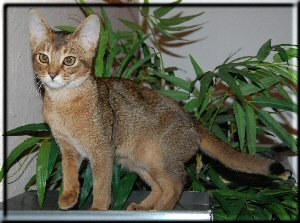

In [11]:
display(Image(os.path.join(input_dir,images[71])))

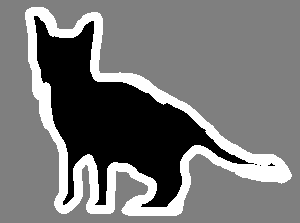

In [12]:
ImageOps.autocontrast(load_img(os.path.join(annotations_dir,targets[71])))

## Preprocessing Opts: Creating a preprocessing pipe-line

In [13]:
from tensorflow import keras as k
import numpy as np

In [69]:
class image_preprocessing(k.utils.Sequence):
  def __init__(self, batch_size, img_size, input_images, target_images, input_dir, target_dir):
    self.batch_size = batch_size
    self.img_size = img_size
    self.input_dir = input_dir
    self.target_dir = target_dir
    self.input_images = input_images 
    self.target_images = target_images
  
  def __len__(self):
    return len(self.target_images)//self.batch_size

  def __getitem__(self, index):
    i = index*self.batch_size
    batch_inputs = self.input_images[i : i+self.batch_size]
    batch_targets = self.target_images[i : i+self.batch_size]

    x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype ="float32")
    for j, path in enumerate(batch_inputs):
      img = load_img(os.path.join(self.input_dir,path), target_size = self.img_size)
      x[j] = img
    
    y = np.zeros((self.batch_size,)+self.img_size+(1,), dtype ="uint8")
    for j, path in enumerate(batch_targets):
      img=load_img(os.path.join(self.target_dir,path), target_size=self.img_size, color_mode="grayscale")
      y[j] = np.expand_dims(img, 2)
      y[j] -= 1
    return x,y

##Defining the model:


In [82]:
def create_unet_model(image_size, n_classes):
    input_ = k.layers.Input((image_size, image_size, 3))

    x = k.layers.Conv2D(32, 3, strides = 2, padding = "same")(input_)
    x = k.layers.BatchNormalization()(x)
    x = k.layers.Activation("relu")(x)

    previous_block_activation = x

    for filters in [64, 128, 256]:
        x = k.layers.Activation("relu")(x)
        x = k.layers.SeparableConv2D(filters, 3, padding = "same")(x)
        x = k.layers.BatchNormalization()(x)

        x = k.layers.Activation("relu")(x)
        x = k.layers.SeparableConv2D(filters, 3, padding = "same")(x)
        x = k.layers.BatchNormalization()(x)

        x = k.layers.MaxPooling2D(3, strides = 2, padding = "same")(x)

        # residuals
        resid = k.layers.Conv2D(filters, 1, strides = 2, padding = "same")(previous_block_activation)
        x = k.layers.add([x, resid])    # add resid block
        previous_block_activation = x
    
    previous_block_activation = x    # residual
    for filters in [256, 128, 64, 32]:
        x = k.layers.Activation("relu")(x)
        x = k.layers.Conv2DTranspose(filters, 3, padding = "same")(x)
        x = k.layers.BatchNormalization()(x)


        x = k.layers.Activation("relu")(x)
        x = k.layers.Conv2DTranspose(filters, 3, padding = "same")(x)
        x = k.layers.BatchNormalization()(x)

        x = k.layers.UpSampling2D(2)(x)

        # residuals
        resid = k.layers.UpSampling2D(2)(previous_block_activation)
        resid = k.layers.Conv2D(filters, 1, padding = "same")(resid)
        x = k.layers.add([x, resid])
        previous_block_activation = x 

    # Add a pixel level classification layer
    output_ = k.layers.Conv2D(n_classes, 3, activation = "softmax", padding = "same")(x)
    unet_model = k.Model(input_, output_)
    return unet_model  

In [83]:
k.backend.clear_session()

model = create_unet_model(128,3)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

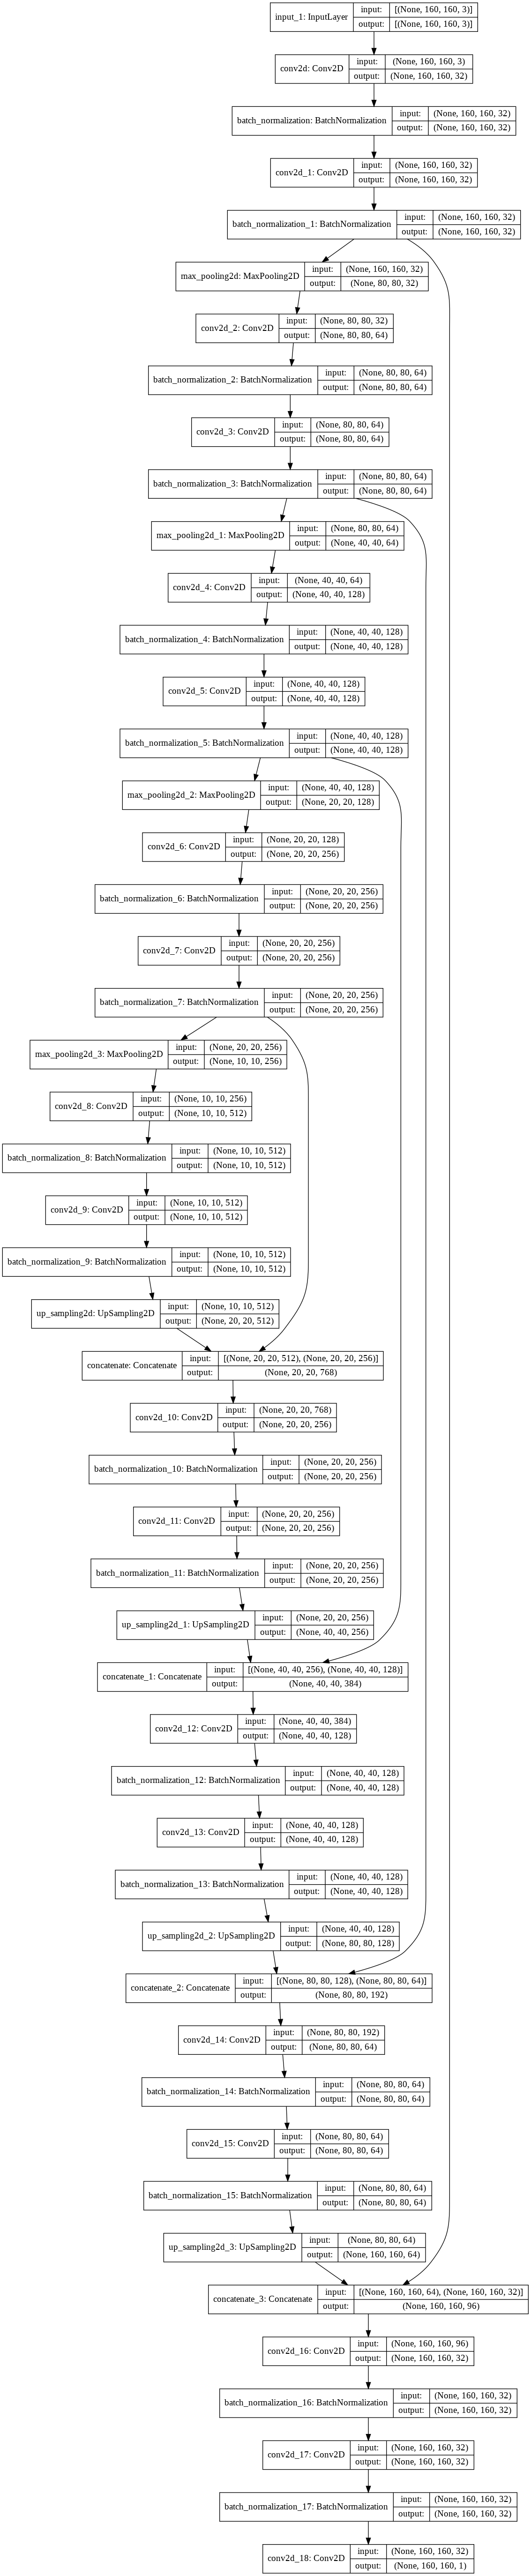

In [47]:
k.utils.plot_model(model, show_shapes=True)

### Splitting the dataset:

In [48]:
import random

In [26]:
val_size = 1000
seed = 2020
random.Random(seed).shuffle(images)
random.Random(seed).shuffle(targets)

train_input = images[:-val_size]
train_output = targets[:-val_size]

val_input = images[-val_size:]
val_output = targets[-val_size:]

## Creating the training and validation generators:

In [84]:
train_gen = image_preprocessing(batch_size=32, img_size=(128,128), input_images=train_input, target_images=train_output, input_dir=input_dir, target_dir=annotations_dir)
val_gen   = image_preprocessing(batch_size=32, img_size=(128,128), input_images=val_input, target_images=val_output, input_dir=input_dir, target_dir=annotations_dir)

## Callbacks:

In [85]:
callbacks =[k.callbacks.ModelCheckpoint(os.path.join(base_dir,"image_seg.h5"),save_best_only=True)]

### Training the model:

In [ ]:
history = model.fit(train_gen, epochs = 30, validation_data=val_gen, callbacks=callbacks)

Epoch 1/30
199/199 [==============================] - 59s 297ms/step - loss: 0.2585 - acc: 0.3093 - val_loss: 0.4277 - val_acc: 0.2837
Epoch 2/30
199/199 [==============================] - 59s 297ms/step - loss: 0.2413 - acc: 0.3082 - val_loss: 0.4417 - val_acc: 0.3314
Epoch 3/30
199/199 [==============================] - 58s 292ms/step - loss: 0.2287 - acc: 0.3075 - val_loss: 0.4444 - val_acc: 0.3148
Epoch 4/30
199/199 [==============================] - 58s 293ms/step - loss: 0.2143 - acc: 0.3066 - val_loss: 0.4669 - val_acc: 0.2959
Epoch 5/30
123/199 [=================>............] - ETA: 19s - loss: 0.2077 - acc: 0.3060

## Analyzing the loss:

In [ ]:
loss = history['']